#Zasoby

* Make predictions with scikit-learn models in ONNX format

* https://cloud.google.com/bigquery/docs/e2e-journey
* https://cloud.google.com/bigquery/docs/making-predictions-with-sklearn-models-in-onnx-format
* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-onnx

#Cele

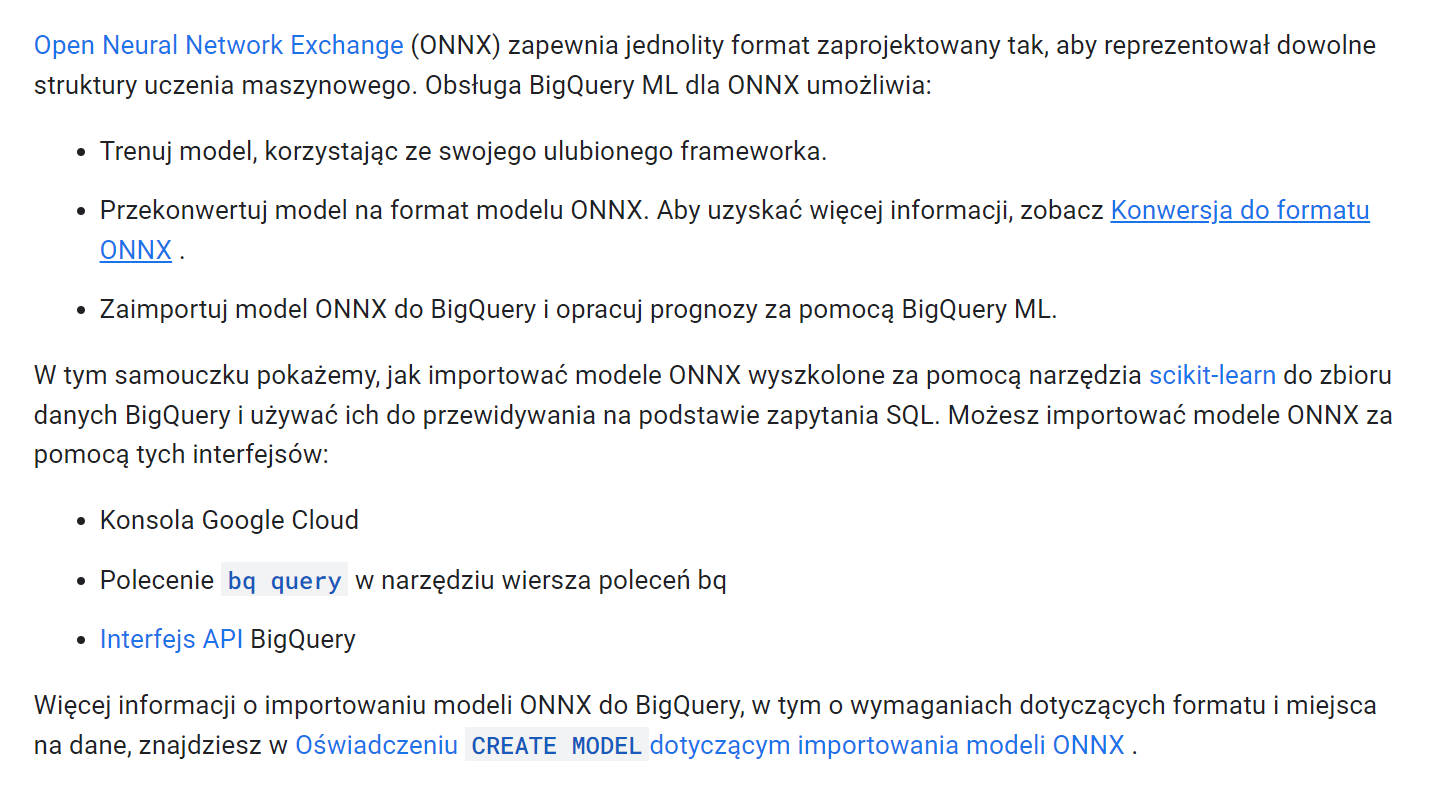

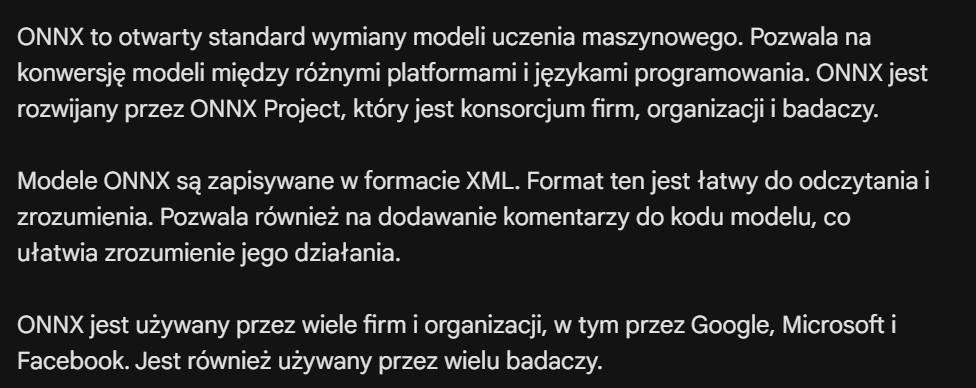

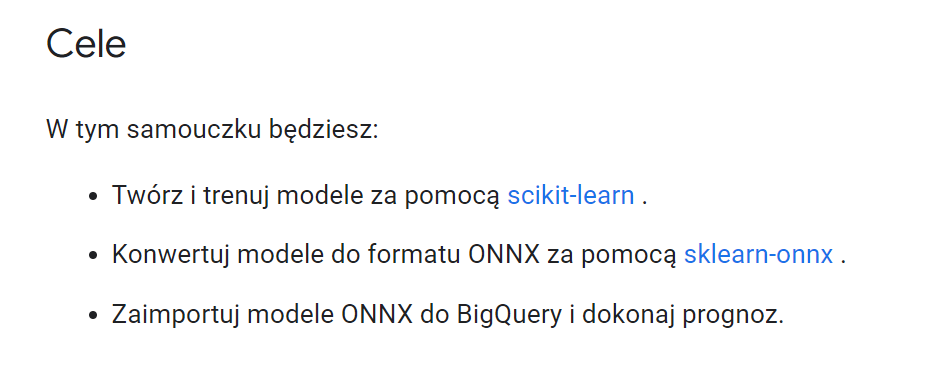

#Trenuj model klasyfikacji za pomocą narzędzia scikit-learn (Krok 1)

In [ ]:
import numpy
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

data = load_iris()
X = data.data[:, :4]
y = data.target

ind = numpy.arange(X.shape[0])
numpy.random.shuffle(ind)
X = X[ind, :].copy()
y = y[ind].copy()

pipe = Pipeline([('scaler', StandardScaler()),
                ('clr', RandomForestClassifier())])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clr', RandomForestClassifier())])

#Przekonwertuj model do formatu ONNX i zapisz (Krok 2)

In [ ]:
# https://pypi.org/project/skl2onnx/

In [ ]:
pip install skl2onnx

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Disable zipmap as it is not supported in BigQuery ML.
options = {id(pipe): {'zipmap': False}}

# Define input features. scikit-learn does not store information about the
# training dataset. It is not always possible to retrieve the number of features
# or their types. That's why the function needs another argument called initial_types.
initial_types = [
   ('sepal_length', FloatTensorType([None, 1])),
   ('sepal_width', FloatTensorType([None, 1])),
   ('petal_length', FloatTensorType([None, 1])),
   ('petal_width', FloatTensorType([None, 1])),
]

# Convert the model.
model_onnx = convert_sklearn(
   pipe, 'pipeline_rf', initial_types=initial_types, options=options
)

# And save.
with open('pipeline_rf.onnx', 'wb') as f:
 f.write(model_onnx.SerializeToString())

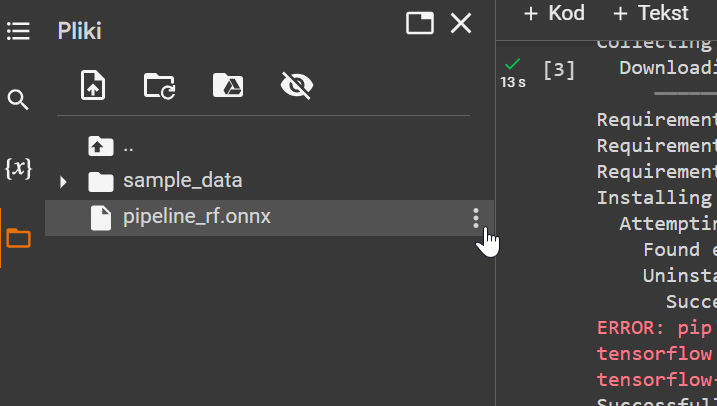

#Prześlij model ONNX do Cloud Storage (Krok 3)

In [ ]:
# gs://model_gcs/pipeline_rf.onnx

#Zaimportuj model ONNX do BigQuery (Krok 4)

In [ ]:
%%bigquery

 CREATE OR REPLACE MODEL pmackowka_us.model_0171
  OPTIONS (MODEL_TYPE='ONNX',
   MODEL_PATH='gs://model_gcs/pipeline_rf.onnx')

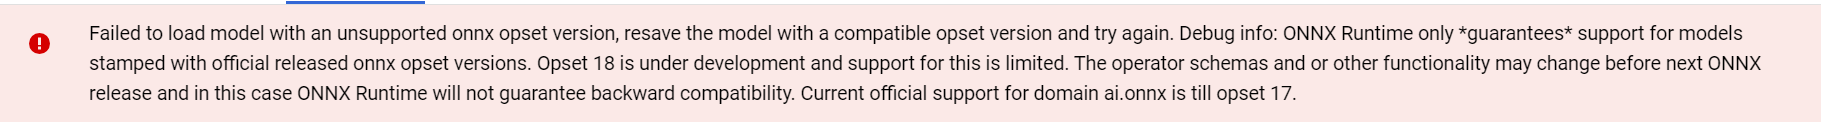

#Dokonuj prognoz za pomocą zaimportowanego modelu ONNX (Krok 5)

In [ ]:
%%bigquery

 SELECT *
   FROM ML.PREDICT(MODEL pmackowka_us.model_0171,
     (
      SELECT * FROM bigquery-public-data.ml_datasets.iris
     )
 )
